# Modèle pre-entrainer DENSE121 : classification binaire COVID / SAIN (NORMAL) par extraction de features

In [1]:
# Chargement des modules necessaire :

import os

import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Model

In [2]:
# On declare les chemins vers les donnees :

trainDir = 'Data/TRAIN'
validationDir = 'Data/TEST'
 
# On declare les dimensions pour les images (224,224) :
img_width, img_height = 224, 224

# On liste et stocke les chemins des images :
ImageTRAINCOVID = os.listdir(trainDir + '/COVID')
ImageTRAINNORMAL = os.listdir(trainDir + '/NORMAL')

ImageTESTCOVID = os.listdir(validationDir + '/COVID')
ImageTESTNORMAL = os.listdir(validationDir + '/NORMAL')

# On affiche le nombre d'image trouve :
print('Il y a ' + str(len(ImageTRAINCOVID)) + ' images d\'entrainement de patient covid.') 
print('Il y a ' + str(len(ImageTRAINNORMAL)) + ' images d\'entrainement de patient non-covid.') 
print('Il y a ' + str(len(ImageTESTCOVID)) + ' images test de patient covid.') 
print('Il y a ' + str(len(ImageTESTNORMAL)) + ' images test de patient non-covid.')

Il y a 460 images d'entrainement de patient covid.
Il y a 1266 images d'entrainement de patient non-covid.
Il y a 219 images test de patient covid.
Il y a 1341 images test de patient non-covid.


TRAIN COVID


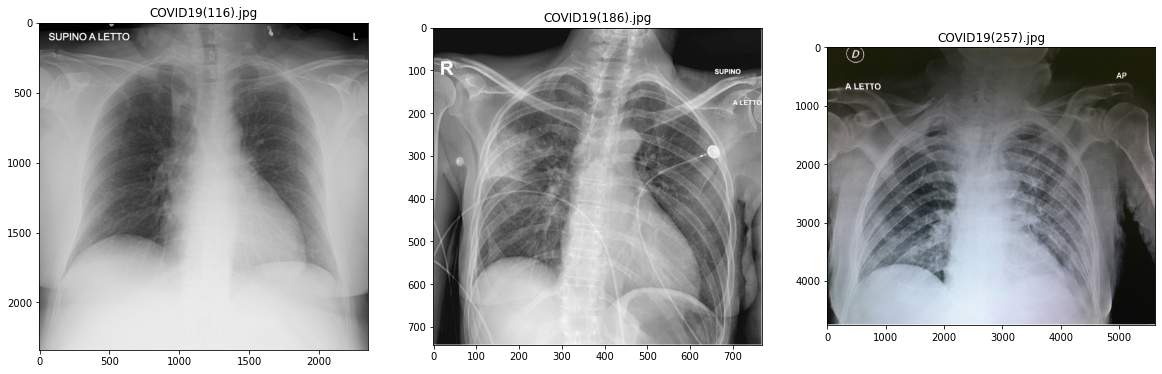

TEST COVID


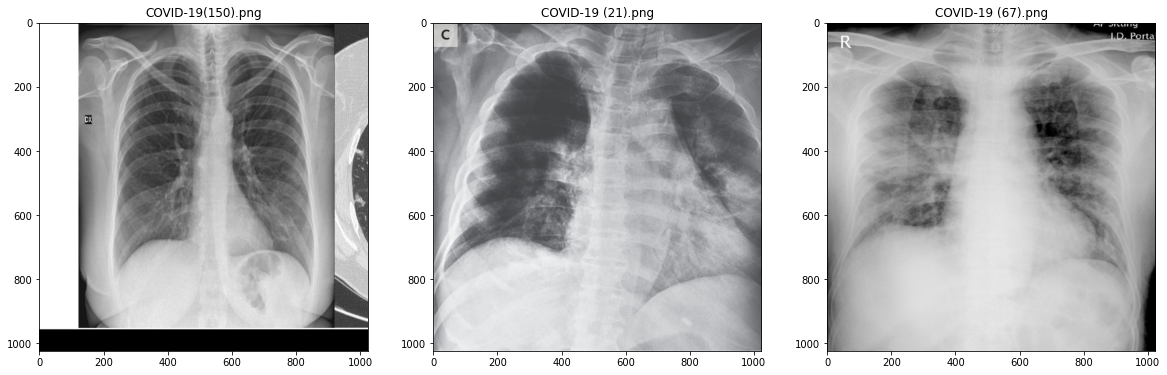

TRAIN NORMAL


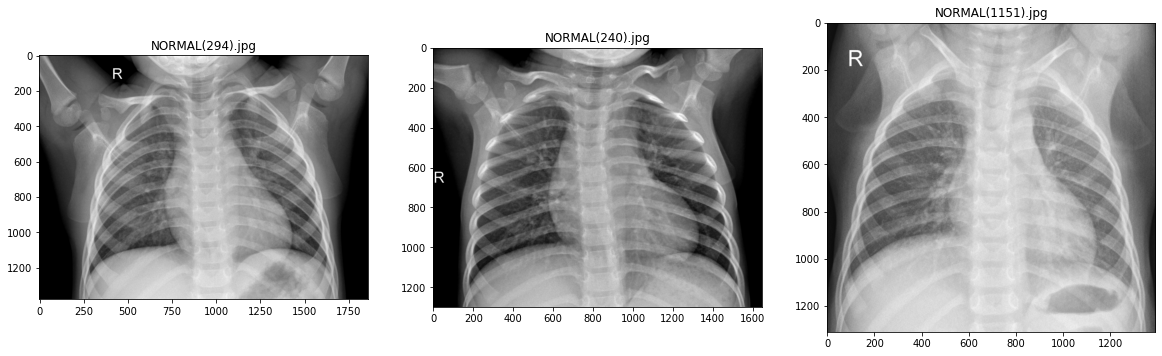

TEST NORMAL


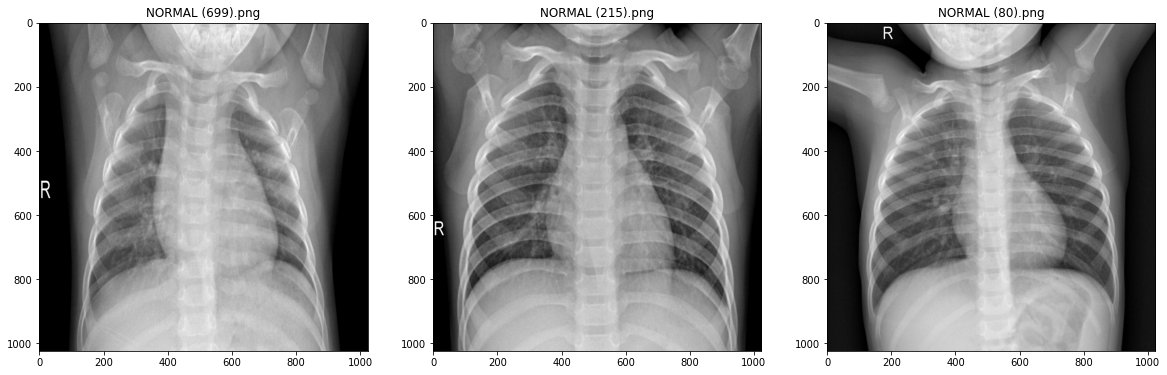

In [3]:
# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# TRAIN :

print("TRAIN COVID")


# COVID  :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINCOVID = random.choice(os.listdir(trainDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/COVID',randomImageTRAINCOVID)), cmap='gray')
    plt.title(randomImageTRAINCOVID)
    
plt.show()

print("TEST COVID")
# COVID  :
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTCOVID = random.choice(os.listdir(validationDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( validationDir +'/COVID',randomImageTESTCOVID)), cmap='gray')
    plt.title(randomImageTESTCOVID)
    
plt.show()

print("TRAIN NORMAL")
# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINNORMAL = random.choice(os.listdir(trainDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/NORMAL',randomImageTRAINNORMAL)), cmap='gray')
    plt.title(randomImageTRAINNORMAL)
    
plt.show()


# TEST:

print("TEST NORMAL")

# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTNORMAL = random.choice(os.listdir(validationDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join(validationDir +'/NORMAL',randomImageTESTNORMAL)), cmap='gray')
    plt.title(randomImageTESTNORMAL)
    
plt.show()

In [4]:
# Preprocessing :
# On rescale les images :
datagen = ImageDataGenerator(rescale=1./255)

# On definit la batch size :
batch_size = 32

# On prepare les tableaux de donnees depuis les images :
train_generator = datagen.flow_from_directory(
        trainDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator = datagen.flow_from_directory(
        validationDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 1726 images belonging to 2 classes.
Found 1560 images belonging to 2 classes.


In [5]:
# Chargement de DENSE121 sans la partie fully-connected avec le reseau convolutif :

model_dense = applications.DenseNet121(include_top=False, weights='imagenet')

In [6]:
# On utilse le model VGG16 pour extraire les features de nos images 
# (on fait recupere la sortie du reseau convolutionnel) :
train_features = model_dense.predict_generator(train_generator, 1726 // batch_size)

validation_features = model_dense.predict_generator(validation_generator, 433 // batch_size)

# L'opération étant longue on enregistre les features obtenus :
np.save(open('models/trainFeatures_DENSE121_AllData.npy', 'wb'), train_features) # ecriture en binaire necessaire
np.save(open('models/validationFeatures_DENSE121_AllData.npy', 'wb'), validation_features) # Idem

/Users/chourouk/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [7]:
# Si l'operation à deja été effectuer on charge les features :

train_features = np.load(open('models/trainFeatures_DENSE121_AllData.npy', 'rb'))
validation_features = np.load(open('models/validationFeatures_DENSE121_AllData.npy', 'rb'))

In [8]:
# On definit les labels :

train_labels = np.array([0] * 448 + [1] * 1248)

validation_labels = np.array([0] * 116 + [1] * 300)

# On peut maintenat tester plusieurs couches fully-connected à partir de ce modele :

In [9]:
# Premier modele : 
model_top1 = Sequential()
model_top1.add(Flatten(input_shape=train_features.shape[1:]))
model_top1.add(Dense(64, activation='relu'))
model_top1.add(Dropout(0.5))
model_top1.add(Dense(1, activation='sigmoid'))


# On compile :
model_top1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# On affiche :
model_top1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3211328   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,211,393
Trainable params: 3,211,393
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Second modele :
model_top2 = Sequential()
model_top2.add(Flatten(input_shape=train_features.shape[1:]))
model_top2.add(Dense(128, activation='relu'))
model_top2.add(Dropout(0.5))
model_top2.add(Dense(1, activation='sigmoid'))

# On compile :
model_top2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# On affiche :
model_top2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,422,785
Trainable params: 6,422,785
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Troisieme modele :
model_top3 = Sequential()
model_top3.add(Flatten(input_shape=train_features.shape[1:]))
model_top3.add(Dense(256, activation='relu'))
model_top3.add(Dropout(0.5))
model_top3.add(Dense(1, activation='sigmoid'))

# On compile :
model_top3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               12845312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 12,845,569
Trainable params: 12,845,569
Non-trainable params: 0
_________________________________________________________________


In [12]:
# On definit les parametres pour l'entrainement :
epochs = 10

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto',restore_best_weights= True),
]

In [13]:
# On entraine le modèle 1 :

history1 = model_top1.fit(train_features, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels),
                         callbacks=my_callbacks)

Epoch 1/10
53/53 [==============================] - 13s 177ms/step - loss: 6.4864 - accuracy: 0.8480 - val_loss: 2.6399 - val_accuracy: 0.7404
Epoch 2/10
53/53 [==============================] - 4s 85ms/step - loss: 0.6631 - accuracy: 0.9435 - val_loss: 1.2260 - val_accuracy: 0.7428
Epoch 3/10
53/53 [==============================] - 5s 87ms/step - loss: 0.4267 - accuracy: 0.9475 - val_loss: 2.5159 - val_accuracy: 0.7548


In [14]:
# On entraine le modèle 2:

history2 = model_top2.fit(train_features, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels),callbacks=my_callbacks)

Epoch 1/10
53/53 [==============================] - 18s 247ms/step - loss: 7.1381 - accuracy: 0.8503 - val_loss: 3.7248 - val_accuracy: 0.7380
Epoch 2/10
53/53 [==============================] - 9s 166ms/step - loss: 0.1954 - accuracy: 0.9659 - val_loss: 1.8148 - val_accuracy: 0.7524
Epoch 3/10
53/53 [==============================] - 8s 155ms/step - loss: 0.2112 - accuracy: 0.9644 - val_loss: 1.6054 - val_accuracy: 0.7019
Epoch 4/10
53/53 [==============================] - 8s 160ms/step - loss: 0.2940 - accuracy: 0.9610 - val_loss: 2.9471 - val_accuracy: 0.7524


In [ ]:
# On entraine le modèle 3:

history3 = model_top3.fit(train_features, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels),callbacks=my_callbacks)

Epoch 1/10
53/53 [==============================] - 27s 472ms/step - loss: 8.1510 - accuracy: 0.8673 - val_loss: 11.7344 - val_accuracy: 0.7548
Epoch 2/10
53/53 [==============================] - 23s 445ms/step - loss: 0.4860 - accuracy: 0.9800 - val_loss: 8.4435 - val_accuracy: 0.7644
Epoch 3/10
23/53 [============>.................] - ETA: 13s - loss: 0.2365 - accuracy: 0.9774

In [ ]:
# Visualisation de l'entrainement : 

epochs = range(1,11)
plt.plot(epochs, history1.history['accuracy'], label='Accuracy')
plt.plot(epochs, history1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history1.history['loss'], label='Loss')
plt.plot(epochs, history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the light layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

epochs = range(1,11)
plt.plot(epochs, history2.history['accuracy'], label='Accuracy')
plt.plot(epochs, history2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history2.history['loss'], label='Loss')
plt.plot(epochs, history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the medium layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

epochs = range(1,11)
plt.plot(epochs, history3.history['accuracy'], label='Accuracy')
plt.plot(epochs, history3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history3.history['loss'], label='Loss')
plt.plot(epochs, history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the heavy layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

In [ ]:
# On evalue :

# Avec les donnes de validation :

eval1 = model_top1.evaluate(validation_features, validation_labels,verbose=2)
eval2 = model_top2.evaluate(validation_features, validation_labels,verbose=2)
eval3 = model_top3.evaluate(validation_features, validation_labels,verbose=2)


## Enregistrements (facultatifs)

In [ ]:
# On enregistre le poids du model (eventuel) :
model_top1.save_weights('../memory/Weights/dense121_lightTop_224_224_10G.h5')
model_top2.save_weights('../memory/Weights/dense121_mediumTop_224_224_10G.h5')
model_top3.save_weights('../memory/Weights/dense121_heavyTop_224_224_10G.h5')

In [ ]:
#On enregistre le modele en entier:

model_top3.save("../memory/FullModels/dense121_heavyTop_224_224_10G")
model_top2.save("../memory/FullModels/dense121_mediumTop_224_224_10G")
model_top1.save("../memory/FullModels/dense121_lightTop_224_224_10G")

In [ ]:
    #On enregistre l'historique:
np.save('../memory/history/historique_chourouk_dense121_224_224_light_10G.npy',history1.history)
np.save('../memory/history/historique_chourouk_dense121_224_224_medium_10G.npy',history2.history)
np.save('../memory/history/historique_chourouk_dense121_224_224_heavy_10G.npy',history3.history)